# Markov Chains and Hidden Markov Models

**COMP9418-20T3, W05 Tutorial**

- Instructor: Gustavo Batista
- School of Computer Science and Engineering, UNSW Sydney 
- Questions by Gustavo Batista

In this week's tutorial, we will explore models that use the Markovian assumptions, in particular Markov chains and Hidden Markov Models. We will implement the forward and Viterbi algorithms and use them to gain intuition about the convergence of Markov chains, and the probabilitic queries these algorithms can answer. 

## Technical prerequisites

You will need certain packages installed to run this notebook.

If you are using ``conda``'s default
[full installation](https://conda.io/docs/install/full.html),
these requirements should all be satisfied already.

If you are using ``virtualenv`` or other native package management,
you may need to run these commands:

```python
pip3 install numpy matplotlib
```

To render a visualization of some graphical models, you also need to install Graphviz [download page](http://www.graphviz.org/download). We have already used this library in Tutorial 1, thus, you should have it installed. If you do not have it and use the conda installation, then use the command ```conda install python-graphviz```.

Once we have done all that, we
import some useful modules for later use.

In [3]:
# Make division default to floating-point, saving confusion
from __future__ import division
from __future__ import print_function

# Necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# combinatorics
from itertools import product, combinations
# ordered dictionaries are useful for keeping ordered sets of varibles
from collections import OrderedDict as odict
# table formating for screen output
from tabulate import tabulate
#visualise graphs
from graphviz import Digraph

## Markov Chains

Let's start implementing the mini-forward algorithm for Markov chains. We will use this algorithm to calculate the probability of a sequence of events as well as testing the convergence of some chains.

Remember from the course slides that a Markov chain (as well as the Hidden Markov Model) is a Dynamic Bayesian Network (DBN). It means that this network "grows", i.e., we can add nodes as we iterate over time or space. We need to specify a notation to indicate time passage. Similarly to the slides, we use $t-1$ and $t$ appended to the variables names to designate the previous time and present time.

We can use the example from the slides to introduce the notation and write the first transition tables.

![](./img/weather.png)

To define a Markov chain, we need to set the outcomeSpace as well as initial state and the transition probabilities. We will write the first two and let the third one as an exercise.

In [4]:
# possible outcomes, by variable
outcomeSpace = {
    'Weather_t-1':('sun','rain'),    
    'Weather_t':('sun','rain'),
}

# The start state, in this case let's assume we start in a sunny day
weatherStart = {
    'dom': ('Weather',), 
    'table': odict([
        (('sun',), 1.0),
        (('rain',), 0.0),
    ])
}

### Exercise

Now, it is your turn. Define the transition probability table according to the figure above. We have created an initial table for you.

In [5]:
weatherTransition = {
    'dom': ('Weather_t-1', 'Weather_t'), 
    'table': odict([
        (('sun','sun'), 0.9),
        (('sun','rain'), 0.1),
        (('rain','sun'), 0.3),
        (('rain','rain'), 0.7),
    ])
}

In [6]:
# Answer

weatherTransition = {
    'dom': ('Weather_t-1', 'Weather_t'), 
    'table': odict([
        (('sun','sun'), 0.9),
        (('sun','rain'), 0.1),
        (('rain','sun'), 0.3),
        (('rain','rain'), 0.7),
    ])
}

We can double-check our work with the `graphviz` library. The source code bellow draws a state transition graph based on the `weatherTransition` table that you just defined. Compare the `graphviz` plot with the slide figure to confirm your state transition probabilities are correct.

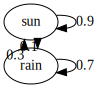

In [7]:
dot = Digraph(engine="neato", comment='Weather Markov chain')
dot.attr(overlap="false", splines="false")

pos = {
    'sun': '0,1!',
    'rain': '0,0!',    
}

for v in outcomeSpace['Weather_t']:
    dot.node(v, pos=pos[v])

for v in outcomeSpace['Weather_t']:
    for w in outcomeSpace['Weather_t']:
        dot.edge(v, w, str(weatherTransition['table'][(v,w)]))
        
dot

We can now implement the mini-forward algoritm for Markov chains. Remember from the slides that the update rule for the forward simulation is the following:

$P(x_t) = \sum_{x_{t-1}}P(x_t | x_{t-1})P(x_{t-1})$

- $P(x_{t-1})$ is the previous state probability table.

- $P(x_t | x_{t-1})$ is the transition probability table such as the one you defined in the previous exercise.

- $P(x_t)$ is the current state probability table.

From this equation, it is clear we need two basic operations. One is the multiplication of factors (probability tables) that we implemented in a previous tutorial as a `joint` operation. The second one summing one variable out that we implemented as a `marginalize` operation.

Let's bring these two functions as well as the `prob` and `printFactor` subroutines we implemented in previous tutorials. We recommend that you use your implementations.

In [9]:
def printFactor(f):
    """
    argument 
    `f`, a factor to print on screen
    """
    # Create a empty list that we will fill in with the probability table entries
    table = list()
    
    # Iterate over all keys and probability values in the table
    for key, item in f['table'].items():
        # Convert the tuple to a list to be able to manipulate it
        k = list(key)
        # Append the probability value to the list with key values
        k.append(item)
        # Append an entire row to the table
        table.append(k)
    # dom is used as table header. We need it converted to list
    dom = list(f['dom'])
    # Append a 'Pr' to indicate the probabity column
    dom.append('Pr')
    print(tabulate(table, headers=dom, tablefmt='orgtbl'))

def prob(factor, *entry):
    """
    argument 
    `factor`, a dictionary of domain and probability values,
    `entry`, a list of values, one for each variable in the same order as specified in the factor domain.
    
    Returns p(entry)
    """

    return factor['table'][entry]     # insert your code here, 1 line   

def join(f1, f2, outcomeSpace):
    """
    argument 
    `f1`, first factor to be joined.
    `f2`, second factor to be joined.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns a new factor with a join of f1 and f2
    """
    
    # First, we need to determine the domain of the new factor. It will be union of the domain in f1 and f2
    # But it is important to eliminate the repetitions
    common_vars = list(f1['dom']) + list(set(f2['dom']) - set(f1['dom']))
    
    # We will build a table from scratch, starting with an empty list. Later on, we will transform the list into a odict
    table = list()
    
    # Here is where the magic happens. The product iterator will generate all combinations of varible values 
    # as specified in outcomeSpace. Therefore, it will naturally respect observed values
    for entries in product(*[outcomeSpace[node] for node in common_vars]):
        
        # We need to map the entries to the domain of the factors f1 and f2
        entryDict = dict(zip(common_vars, entries))
        f1_entry = (entryDict[var] for var in f1['dom'])
        f2_entry = (entryDict[var] for var in f2['dom'])
        
        # Insert your code here
        p1 = prob(f1, *f1_entry)           # Use the fuction prob to calculate the probability in factor f1 for entry f1_entry 
        p2 = prob(f2, *f2_entry)           # Use the fuction prob to calculate the probability in factor f2 for entry f2_entry 
        
        # Create a new table entry with the multiplication of p1 and p2
        table.append((entries, p1 * p2))
    return {'dom': tuple(common_vars), 'table': odict(table)}


def marginalize(f, var, outcomeSpace):
    """
    argument 
    `f`, factor to be marginalized.
    `var`, variable to be summed out.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns a new factor f' with dom(f') = dom(f) - {var}
    """    
    
    # Let's make a copy of f domain and convert it to a list. We need a list to be able to modify its elements
    new_dom = list(f['dom'])
    
    new_dom.remove(var)            # Remove var from the list new_dom by calling the method remove(). 1 line
    table = list()                 # Create an empty list for table. We will fill in table from scratch. 1 line
    for entries in product(*[outcomeSpace[node] for node in new_dom]):
        s = 0;                     # Initialize the summation variable s. 1 line

        # We need to iterate over all possible outcomes of the variable var
        for val in outcomeSpace[var]:
            # To modify the tuple entries, we will need to convert it to a list
            entriesList = list(entries)
            # We need to insert the value of var in the right position in entriesList
            entriesList.insert(f['dom'].index(var), val)
            
            p = prob(f, *tuple(entriesList))     # Calculate the probability of factor f for entriesList. 1 line
            s = s + p                            # Sum over all values of var by accumulating the sum in s. 1 line
            
        # Create a new table entry with the multiplication of p1 and p2
        table.append((entries, s))
    return {'dom': tuple(new_dom), 'table': odict(table)}

### Exercise

Let's implement the miniForward algorithm for Markov chains. We start with the online version that makes a single update (one time step). We use the online version to implement the batch one that runs multiple time steps.

In [ ]:
def miniForwardOnline(f, transition, outcomeSpace):
    """
    argument 
    `f`, factor that represents the previous state of the chain.
    `transition`, transition probabilities from time t-1 to t.
    `outcomeSpace`, dictionary with the domain of each variable.
    
    Returns a new factor that represents the current state of the chain.
    """

    # Make a copy of f so we will not modify the original factor
    fPrevious = f.copy()                                          # 1 line
    # Name of the random variable. f domain should be a list with a single element
    randVariable = fPrevious['dom'][0]
    # Set the f_previous domain to be a list with a single variable name appended with '_t-1' to indicate previous time step
    fPrevious['dom'] = (randVariable + '_t-1', )
    # Make the join operation between fPrevious and the transition probability table
    fCurrent = None                                           # 1 line
    # Marginalize the randVariable_t-1
    fCurrent = None                                           # 1 line
    # Set the domain of fCurrent to be name of the random variable without time index
    fCurrent['dom'] = (randVariable, )
    return fCurrent

##################
# Test code

printFactor(miniForwardOnline(weatherStart, weatherTransition, outcomeSpace))

In [12]:
# Answer

def miniForwardOnline(f, transition, outcomeSpace):
    """
    argument 
    `f`, factor that represents the previous state of the chain.
    `transition`, transition probabilities from time t-1 to t.
    `outcomeSpace`, dictionary with the domain of each variable.
    
    Returns a new factor that represents the current state of the chain.
    """

    # Make a copy of f so we will not modify the original factor
    fPrevious = f.copy()                                          
    # Name of the random variable. f domain should be a list with a single element
    randVariable = fPrevious['dom'][0]                                     
    # Set the f_previous domain to be a list with a single variable name appended with '_t-1' to indicate previous time step
    fPrevious['dom'] = (randVariable + '_t-1', )                  
    # Make the join operation between fPrevious and the transition probability table
    fCurrent = join(fPrevious, transition, outcomeSpace)
    # Marginalize the randVariable_t-1
    fCurrent = marginalize(fCurrent, fPrevious['dom'][0], outcomeSpace)
    # Set the domain of fCurrent to be name of the random variable without time index
    fCurrent['dom'] = (randVariable, )
    return fCurrent

##################
# Test code

printFactor(miniForwardOnline(weatherStart, weatherTransition, outcomeSpace))

| Weather   |   Pr |
|-----------+------|
| sun       |  0.9 |
| rain      |  0.1 |


If your implementation is correct, you should have the following output:

```
| Weather   |   Pr |
|-----------+------|
| sun       |  0.9 |
| rain      |  0.1 |
```

We can use the mini-forward online implementation to make a simple batch extension that calls the online subroutine a fixed number of times.

### Exercise

Implement the batch version of the mini-forward algorithm for Markov chains

In [ ]:
def miniForwardBatch(f, transition, outcomeSpace, n):
    """
    argument 
    `f`, factor that represents the previous state of the chain.
    `transition`, transition probabilities from time t-1 to t.
    `outcomeSpace`, dictionary with the domain of each variable.
    `n`, number of time updates
    
    Returns a new factor that represents the current state of the chain after n time steps.
    """

    # fCurrent is a copy of f, so we will not overwrite f in the for loop
    fCurrent = f.copy()
    for i in range(n):
        # Call miniForwardOnline to update fCurrent
        fCurrent = None                                                        # 1 line
        # Print fCurrent to debug the results
        printFactor(fCurrent)
        print()
    # return fCurrent
    return fCurrent
        
###################
# Test code

printFactor(miniForwardBatch(weatherStart, weatherTransition, outcomeSpace, 3))

In [13]:
# Answer

def miniForwardBatch(f, fTransition, outcomeSpace, n):
    """
    argument 
    `f`, factor that represents the previous state of the chain.
    `fTransition`, transition probabilities from time t-1 to t.
    `outcomeSpace`, dictionary with the domain of each variable.
    `n`, number of time updates
    
    Returns a new factor that represents the current state of the chain after n time steps.
    """

    # fCurrent is a copy of f, so we will not overwrite f in the for loop
    fCurrent = f.copy()
    for i in range(n):
        # Call miniForwardOnline to update fCurrent
        fCurrent = miniForwardOnline(fCurrent, fTransition, outcomeSpace)
        # Print fCurrent to debug the results
        printFactor(fCurrent)
        print()
    # return fCurrent
    return fCurrent
        
###################
# Test code

printFactor(miniForwardBatch(weatherStart, weatherTransition, outcomeSpace, 3))

| Weather   |   Pr |
|-----------+------|
| sun       |  0.9 |
| rain      |  0.1 |

| Weather   |   Pr |
|-----------+------|
| sun       | 0.84 |
| rain      | 0.16 |

| Weather   |    Pr |
|-----------+-------|
| sun       | 0.804 |
| rain      | 0.196 |

| Weather   |    Pr |
|-----------+-------|
| sun       | 0.804 |
| rain      | 0.196 |


If you implemented your code correctly, you should see the following output:

```
| Weather   |   Pr |
|-----------+------|
| sun       |  0.9 |
| rain      |  0.1 |

| Weather   |   Pr |
|-----------+------|
| sun       | 0.84 |
| rain      | 0.16 |

| Weather   |    Pr |
|-----------+-------|
| sun       | 0.804 |
| rain      | 0.196 |

| Weather   |    Pr |
|-----------+-------|
| sun       | 0.804 |
| rain      | 0.196 |
```

We will now test the convergence of some Markov chains. Remember from the lectures that chains were classified according to two properties:

1. Reducibility. An irreducible (or regular) chain has the property that every state is reachable from every state. Therefore the chain has a single stationary distribution. A reducible chain has not such property and, therefore, can have multiple stationary distributions. The general idea is that, if a chain has, say, two disconnected sets of states **A** and **B** and we start in a state $a \in \textbf{A}$, then we will never reach a state in **B**. In this case, the stationary distribution will depend on the transition probabilities of the states in **A**. The same occurs if we start in a state $b \in \textbf{B}$.

2. Periodicity. An irreducible chain is not guaranteed to convergence. To ensure convergence, we need an additional property: aperiodicity. An aperiodic chain avoids alternating forever between states without ever settling in a stationary distribution. A practical issue in that, although irreducible aperiodic chains are guaranteed to converge to a single stationary distribution, the convergence can be very slow, depending on the transition probabilities.

### Exercise

Let's implement an additional helper function `miniForwardConvergence` that runs until convergence or a maximum number of iterations. We will establish convergence when the error between two consecutive state probability distributions is smaller than a threshold.

Let's start with the implementation of `miniForwardConvergence`. We implemented a helper function `convError` that computes the absolute error between two factors.

In [ ]:
def convError(f1, f2, outcomeSpace):
    """
    argument 
    `f1`, factor with the current state probability distribution in the chain.
    `f2`, factor with the previous state probability distribution in the chain.
    `outcomeSpace`, dictionary with the domain of each variable.    
    
    Returns absolute error between f1 and f2.
    """
    return sum([abs(prob(f1, var) - prob(f2, var)) for var in outcomeSpace[f1['dom'][0]+'_t']])


def miniforwardConvergence(f, transition, outcomeSpace, n = 1000, eps = 0.00001):
    """
    argument 
    `f`, factor that represents the previous state of the chain.
    `transition`, transition probabilities from time t-1 to t.
    `outcomeSpace`, dictionary with the domain of each variable.
    `startDistribution`, initial state probability distribution.
    `n`, maximum number of time updates.
    `eps`, error threshold to determine convergence.
    
    Returns a new factor that represents the current state of the chain after n time steps or the convergence error is less than eps.
    """

    print("  Iter Error\n------ --------")
    # fCurrent is a copy of f, so we will not overwrite f in the for loop
    fCurrent = f.copy()
    # Set an empty list of error, so we can plot the errors later
    errors = []
    for i in range(n):
        # Call miniForwardOnline to compute fNew
        fNew = None                                                                      # 1 line
        # Calculate error between fNew and fCurrent using the convError function
        error = None                                                                     # 1 line
        # Halt the loop if the error is smaller than eps
        if (error < eps):
            break
        # Print a message every 10 iterations to inform the convergence progress
        if (i % 10 == 0):
            print("%6d %1.6f" % (i, error))
        # Store the current error value in a list of error so we can plot it later
        errors.append(error)
        # Updates fCurrent as fNew
        fCurrent = fNew
    #Plot the errors
    plt.plot(errors, 'ro')
    plt.show()

    return fCurrent

######################
# Test code

printFactor(miniforwardConvergence(weatherStart, weatherTransition, outcomeSpace))

  Iter Error
------ --------
     0 0.200000
    10 0.001209


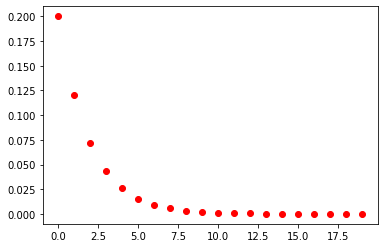

| Weather   |       Pr |
|-----------+----------|
| sun       | 0.750009 |
| rain      | 0.249991 |


In [14]:
# Answer

def convError(f1, f2, outcomeSpace):
    """
    argument 
    `f1`, factor with the current state probability distribution in the chain.
    `f2`, factor with the previous state probability distribution in the chain.
    `outcomeSpace`, dictionary with the domain of each variable.    
    
    Returns absolute error between f1 and f2.
    """
    return sum([abs(prob(f1, var) - prob(f2, var)) for var in outcomeSpace[f1['dom'][0]+'_t']])

def miniforwardConvergence(f, transition, outcomeSpace, n = 1000, eps = 0.00001):
    """
    argument 
    `f`, factor that represents the previous state of the chain.
    `transition`, transition probabilities from time t-1 to t.
    `outcomeSpace`, dictionary with the domain of each variable.
    `startDistribution`, initial state probability distribution.
    `n`, maximum number of time updates.
    `eps`, error threshold to determine convergence.
    
    Returns a new factor that represents the current state of the chain after n time steps or the convergence error is less than eps.
    """

    print("  Iter Error\n------ --------")
    # fCurrent is a copy of f, so we will not overwrite f in the for loop
    fCurrent = f.copy()
    # Set an empty list of error, so we can plot the errors later
    errors = []
    for i in range(n):
        # Call miniForwardOnline to compute fNew
        fNew = miniForwardOnline(fCurrent, transition, outcomeSpace)
        # Calculate error between fNew and fCurrent using the convError function
        error = convError(fNew, fCurrent, outcomeSpace)
        # Halt the loop if the error is smaller than eps
        if (error < eps):
            break
        # Print a message every 10 iterations to inform the convergence progress
        if (i % 10 == 0):
            print("%6d %1.6f" % (i, error))
        # Store the current error value in a list of error so we can plot it later
        errors.append(error)
        # Updates fCurrent as fNew
        fCurrent = fNew
    #Plot the errors
    plt.plot(errors, 'ro')
    plt.show()

    return fCurrent

######################
# Test code

printFactor(miniforwardConvergence(weatherStart, weatherTransition, outcomeSpace))

If you implemented your code correctly, you should see an output like this:

```
  Iter Error
------ --------
     0 0.200000
    10 0.001209

| Weather   |       Pr |
|-----------+----------|
| sun       | 0.750009 |
| rain      | 0.249991 |
```

### Exercise

Now, we can test the convergence of some Markov chains of the previous tutorial. 

The first one has the following transition matrix:

$\begin{bmatrix}
0 & 1 & 0 & 0 \\
1/2 & 0 & 1/2 & 0 \\
0 & 1/2 & 0 & 1/2 \\
0 & 0 & 1 & 0 \\
\end{bmatrix}$
    
This chain is irreducible since we can reach any state from any state. However, it is periodic since if we start from state 1 in time 1, we reach states 1 and 3 at odd times and 2 and 4 at even times. Its stationary distribution is $(1/6, 2/6, 2/6, 1/6)$.

Use the implemented function to confirm that this chain does not converge. Use the next cell to define the necessary variables and call `miniforwardConvergence` function.

In [ ]:
outcomeSpace_c1 = {
    'R_t':(0,1,2,3)
    'R_t-1':(0,1,2,3)
}

transition_c1 = {
    'dom':('R_t-1','R_t'),
    'table':odict([
        ((0,0), 0.0),
        ((0,1), 1.0),
        ((0,2), 0.0),
        ((0,3), 0.0),        
        ((1,0), 0.5),
        ((1,1), 0.0),
        ((1,2), 0.5),
        ((1,3), 0.0),
        ((2,0), 0.0),
        ((2,1), 0.5),
        ((2,2), 0.0),
        ((2,3), 0.5),        
        ((3,0), 0.0),
        ((3,1), 0.0),
        ((3,2), 1.0),
        ((3,3), 0.0),
    ])
}

start_c1 = {
    None
}

printFactor(miniforwardConvergence(start_c1, transition_c1, outcomeSpace_c1))

  Iter Error
------ --------
     0 2.000000
    10 2.000000
    20 2.000000
    30 2.000000
    40 2.000000
    50 2.000000
    60 2.000000
    70 2.000000
    80 2.000000
    90 2.000000
   100 2.000000
   110 2.000000
   120 2.000000
   130 2.000000
   140 2.000000
   150 2.000000
   160 2.000000
   170 2.000000
   180 2.000000
   190 2.000000
   200 2.000000
   210 2.000000
   220 2.000000
   230 2.000000
   240 2.000000
   250 2.000000
   260 2.000000
   270 2.000000
   280 2.000000
   290 2.000000
   300 2.000000
   310 2.000000
   320 2.000000
   330 2.000000
   340 2.000000
   350 2.000000
   360 2.000000
   370 2.000000
   380 2.000000
   390 2.000000
   400 2.000000
   410 2.000000
   420 2.000000
   430 2.000000
   440 2.000000
   450 2.000000
   460 2.000000
   470 2.000000
   480 2.000000
   490 2.000000
   500 2.000000
   510 2.000000
   520 2.000000
   530 2.000000
   540 2.000000
   550 2.000000
   560 2.000000
   570 2.000000
   580 2.000000
   590 2.000000
   600 2.00

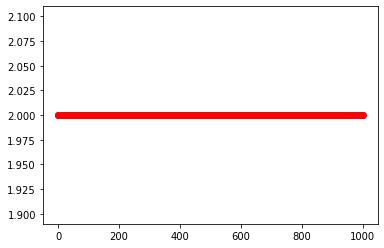

|   R |       Pr |
|-----+----------|
|   0 | 0.333333 |
|   1 | 0        |
|   2 | 0.666667 |
|   3 | 0        |


In [16]:
# Answer

outcomeSpace_c1 = {
    'R_t':(0,1,2,3),
    'R_t-1':(0,1,2,3),
}

transition_c1 = {
    'dom': ('R_t-1', 'R_t'), 
    'table': odict([
        ((0,0), 0.0),
        ((0,1), 1.0),
        ((0,2), 0.0),
        ((0,3), 0.0),        
        ((1,0), 0.5),
        ((1,1), 0.0),
        ((1,2), 0.5),
        ((1,3), 0.0),
        ((2,0), 0.0),
        ((2,1), 0.5),
        ((2,2), 0.0),
        ((2,3), 0.5),        
        ((3,0), 0.0),
        ((3,1), 0.0),
        ((3,2), 1.0),
        ((3,3), 0.0),
    ])
}

start_c1 = {
    'dom': ('R',), 
    'table': odict([
        ((0,), 1.0),
        ((1,), 0.0),
        ((2,), 0.0),
        ((3,), 0.0),        
    ])
}

printFactor(miniforwardConvergence(start_c1, transition_c1, outcomeSpace_c1))

The second one has the following transition matrix:

$\begin{bmatrix}
1/2 & 1/2 & 0 & 0 \\
1/2 & 0 & 1/2 & 0 \\
0 & 1/2 & 0 & 1/2 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}$
    
This chain is reducible since state 4 is absorbing (once entered, cannot be left) and aperiodic. Its stationary distribution is $(0, 0, 0, 1)$.

Use the implemented function to verify this chain convergence. Use the next cell to define the necessary variables and call `miniforwardConvergence` function.

In [ ]:
outcomeSpace_c2 = {
    None
}

transition_c2 = {
    None
}

start_c2 = {
    None
}

printFactor(miniforwardConvergence(start_c2, transition_c2, outcomeSpace_c2))

  Iter Error
------ --------
     0 1.000000
    10 0.086914
    20 0.030042
    30 0.010583
    40 0.003730
    50 0.001315
    60 0.000463
    70 0.000163
    80 0.000058
    90 0.000020


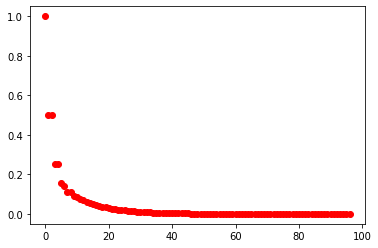

|   R |          Pr |
|-----+-------------|
|   0 | 2.19663e-05 |
|   1 | 1.76156e-05 |
|   2 | 9.7759e-06  |
|   3 | 0.999951    |


In [17]:
# Answer

outcomeSpace_c2 = {
    'R_t':(0,1,2,3),
    'R_t-1':(0,1,2,3),
}

transition_c2 = {
    'dom': ('R_t-1', 'R_t'), 
    'table': odict([
        ((0,0), 0.5),
        ((0,1), 0.5),
        ((0,2), 0.0),
        ((0,3), 0.0),        
        ((1,0), 0.5),
        ((1,1), 0.0),
        ((1,2), 0.5),
        ((1,3), 0.0),
        ((2,0), 0.0),
        ((2,1), 0.5),
        ((2,2), 0.0),
        ((2,3), 0.5),        
        ((3,0), 0.0),
        ((3,1), 0.0),
        ((3,2), 0.0),
        ((3,3), 1.0),
    ])
}

start_c2 = {
    'dom': ('R',), 
    'table': odict([
        ((0,), 1.0),
        ((1,), 0.0),
        ((2,), 0.0),
        ((3,), 0.0),        
    ])
}

printFactor(miniforwardConvergence(start_c2, transition_c2, outcomeSpace_c2))

The third one has the following transition matrix:

$\begin{bmatrix}
1/2 & 1/2 & 0 & 0 \\
1/2 & 1/2 & 0 & 0 \\
0 & 0 & 1/2 & 1/2 \\
0 & 0 & 1/2 & 1/2 \\
\end{bmatrix}$
    
This chain is reducible since we cannot reach states {3,4} from states {1,2} and vice-versa and aperiodic. It has two stationary distributions: $(1/2, 1/2, 0, 0)$ and $(0, 0, 1/2, 1/2)$.

Use the implemented function to verify this chain convergence. Use the next cell to define the necessary variables and call `miniforwardConvergence` function.

In [ ]:
outcomeSpace_c3 = {
    None
}

transition_c3 = {
    None
}

start_c3 = {
    None
}

printFactor(miniforwardConvergence(start_c3, transition_c3, outcomeSpace_c3))

  Iter Error
------ --------
     0 1.000000


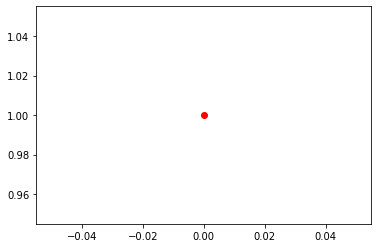

|   R |   Pr |
|-----+------|
|   0 |  0.5 |
|   1 |  0.5 |
|   2 |  0   |
|   3 |  0   |


In [18]:
# Answer

outcomeSpace_c3 = {
    'R_t':(0,1,2,3),
    'R_t-1':(0,1,2,3),
}

transition_c3 = {
    'dom': ('R_t-1', 'R_t'), 
    'table': odict([
        ((0,0), 0.5),
        ((0,1), 0.5),
        ((0,2), 0.0),
        ((0,3), 0.0),        
        ((1,0), 0.5),
        ((1,1), 0.5),
        ((1,2), 0.0),
        ((1,3), 0.0),
        ((2,0), 0.0),
        ((2,1), 0.0),
        ((2,2), 0.5),
        ((2,3), 0.5),        
        ((3,0), 0.0),
        ((3,1), 0.0),
        ((3,2), 0.5),
        ((3,3), 0.5),
    ])
}

start_c3 = {
    'dom': ('R',), 
    'table': odict([
        ((0,), 1.0),
        ((1,), 0.0),
        ((2,), 0.0),
        ((3,), 0.0),        
    ])
}

printFactor(miniforwardConvergence(start_c3, transition_c3, outcomeSpace_c3))

Finally, we have a chain in the form:

$\begin{bmatrix}
1-e & e \\
e & 1-e \\
\end{bmatrix}$
    
This chain is irreducible and aperiodic, but its convergence can be very slow for small values of $e$. It has one stationary distribution: $(1/2, 1/2)$.

Use the implemented function to verify the chain convergence. Change the value of $e$. Use the next cell to define the necessary variables and call `miniforwardConvergence` function.

In [ ]:
e = 0.0001

outcomeSpace_c4 = {
    None
}

transition_c4 = {
    None
}

start_c4 = {
    None
}

printFactor(miniforwardConvergence(start_c4, transition_c4, outcomeSpace_c4))

  Iter Error
------ --------
     0 0.000200
    10 0.000200
    20 0.000199
    30 0.000199
    40 0.000198
    50 0.000198
    60 0.000198
    70 0.000197
    80 0.000197
    90 0.000196
   100 0.000196
   110 0.000196
   120 0.000195
   130 0.000195
   140 0.000194
   150 0.000194
   160 0.000194
   170 0.000193
   180 0.000193
   190 0.000193
   200 0.000192
   210 0.000192
   220 0.000191
   230 0.000191
   240 0.000191
   250 0.000190
   260 0.000190
   270 0.000189
   280 0.000189
   290 0.000189
   300 0.000188
   310 0.000188
   320 0.000188
   330 0.000187
   340 0.000187
   350 0.000186
   360 0.000186
   370 0.000186
   380 0.000185
   390 0.000185
   400 0.000185
   410 0.000184
   420 0.000184
   430 0.000184
   440 0.000183
   450 0.000183
   460 0.000182
   470 0.000182
   480 0.000182
   490 0.000181
   500 0.000181
   510 0.000181
   520 0.000180
   530 0.000180
   540 0.000180
   550 0.000179
   560 0.000179
   570 0.000178
   580 0.000178
   590 0.000178
   600 0.00

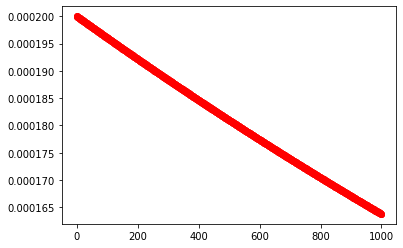

|   R |        Pr |
|-----+-----------|
|   0 | 0.909357  |
|   1 | 0.0906428 |


In [19]:
# Answer

e = 0.0001

outcomeSpace_c4 = {
    'R_t':(0,1),
    'R_t-1':(0,1),
}

transition_c4 = {
    'dom': ('R_t-1', 'R_t'), 
    'table': odict([
        ((0,0), 1-e),
        ((0,1), e),
        ((1,0), e),
        ((1,1), 1-e),        
    ])
}

start_c4 = {
    'dom': ('R',), 
    'table': odict([
        ((0,), 1.0),
        ((1,), 0.0),
    ])
}

printFactor(miniforwardConvergence(start_c4, transition_c4, outcomeSpace_c4))


# PageRank algorithm

The PageRank algorithm is the original algorithm used by Google 1.0. It can be interpreted as a direct application of Markov chains. 

PageRank models the web as a state graph: pages are states and hyperlinks are transitions. The transition probabilities as set as follows:

Imagine you are surfing the web. 
* With 85% probability, you will jump to the next website by randomly selecting from the links on that page. 
* With 15% probability, you will jump randomly to any random page on the graph. 
* If you are at a page with no links, you will always jump to a random page on the graph.

Using these transition probabilities, the PageRank algorithm estimates the stationary distribution over webpages, and uses the probabilities of this distribution as an estimate of the "popularity" of every webpage.

The following figure from [Wikipedia](https://en.wikipedia.org/wiki/PageRank) illustrates the final probabilities (in percentages) of PageRank for a small graph.

![](./img/page_rank.png)

Let's use the mini-forward algorithm to implement the PageRank algorithm. We will use this figure to compare our results. We start by defining this graph. We will do it for you.

In [21]:
# alpha sets the weight portion reserved for regular edges
alpha = .85

outcomePageRank = {
    "P_t-1":('A','B','C','D','E','F','G','H','I','J','K'),
    "P_t":('A','B','C','D','E','F','G','H','I','J','K'),
}

page_graph = {
    "A" : [],
    'B' : ['C'],
    'C' : ['B'],
    'D' : ['B','A'],
    'E' : ['B','D','F'],
    'F' : ['B','E'],
    'G' : ['B','E'],
    'H' : ['B','E'],
    'I' : ['B','E'],
    'J' : ['E'],
    'K' : ['E'],
}

# We set all states with equal initial probabilities
startPageRank = {
    'dom': ('P',), 
    'table': odict([
        (('A',), .091),
        (('B',), .091),
        (('C',), .091),
        (('D',), .091),
        (('E',), .091),
        (('F',), .091),
        (('G',), .091),
        (('H',), .091),
        (('I',), .091),
        (('J',), .091),
        (('K',), .091),        
    ])
}

## Exercise

Fill in the function below to create a transition table according to the rules above. 

In [ ]:
def createTransitionTable(graph, alpha=0.85):
    N = len(graph)
    phantomTransition = {'dom': ('P_t-1', 'P_t'), 'table': odict([])}
    
    # for every pair of nodes in the graph
    for u in outcomePageRank['P_t-1']:
        for v in outcomePageRank['P_t']:
            # find the number of outgoing links
            out_degree = len(graph[u])
            if out_degree == 0:
                # starting at a node 'u' with no neighbors, what's the probability of jumping to v?
                prob_v_given_u = None                                                 # 1 line
            else:
                if v in graph[u]:
                    # starting at 'u', the probability of jumping to a connected node 'v'. 
                    # (Make sure you take into account the 15% possibility of randomly jumping to any node)
                    prob_v_given_u = None                                             # 1 line
                else:
                    # starting at 'u', the probability of jumping to a random node 'v'
                    prob_v_given_u = None                                             # 1 line
            phantomTransition['table'][(u,v)] = prob_v_given_u
    return phantomTransition
            
pageRankTransition = createTransitionTable(page_graph)
printFactor(pageRankTransition)

In [22]:
# Answer
def createTransitionTable(graph, alpha=0.85):
    N = len(graph)
    phantomTransition = {'dom': ('P_t-1', 'P_t'), 'table': odict([])}
    
    # for every pair of nodes in the graph
    for u in outcomePageRank['P_t-1']:
        for v in outcomePageRank['P_t']:
            # find the number of outgoing links
            out_degree = len(graph[u])
            if out_degree == 0:
                # starting at a node 'u' with no neighbors, what's the probability of jumping to v?
                prob_v_given_u = 1/N
            else:
                if v in graph[u]:
                    # starting at 'u', the probability of jumping to a connected node 'v'. 
                    # (Make sure you take into account the 15% possibility of randomly jumping to any node)
                    prob_v_given_u = alpha/out_degree + (1-alpha)/N
                else:
                    # starting at 'u', the probability of jumping to a random node 'v'
                    prob_v_given_u = (1-alpha)/N
            phantomTransition['table'][(u,v)] = prob_v_given_u
    return phantomTransition
            
pageRankTransition = createTransitionTable(page_graph)
printFactor(pageRankTransition)

| P_t-1   | P_t   |        Pr |
|---------+-------+-----------|
| A       | A     | 0.0909091 |
| A       | B     | 0.0909091 |
| A       | C     | 0.0909091 |
| A       | D     | 0.0909091 |
| A       | E     | 0.0909091 |
| A       | F     | 0.0909091 |
| A       | G     | 0.0909091 |
| A       | H     | 0.0909091 |
| A       | I     | 0.0909091 |
| A       | J     | 0.0909091 |
| A       | K     | 0.0909091 |
| B       | A     | 0.0136364 |
| B       | B     | 0.0136364 |
| B       | C     | 0.863636  |
| B       | D     | 0.0136364 |
| B       | E     | 0.0136364 |
| B       | F     | 0.0136364 |
| B       | G     | 0.0136364 |
| B       | H     | 0.0136364 |
| B       | I     | 0.0136364 |
| B       | J     | 0.0136364 |
| B       | K     | 0.0136364 |
| C       | A     | 0.0136364 |
| C       | B     | 0.863636  |
| C       | C     | 0.0136364 |
| C       | D     | 0.0136364 |
| C       | E     | 0.0136364 |
| C       | F     | 0.0136364 |
| C       | G     | 0.0136364 |
| C     

Let's use ``GraphViz`` again to plot this graph and ensure we have designed it correctly. Note that we will not print all $11^2$ conditional probabilities, only the ones that correspond to following a link in the above graph. For a node with one outgoing edge, that edge should have a probability of $0.85 + 0.15\times(1/11) \approx 0.864 $, which is the sum of the probability of following the link $85$% and the probability of randomly choosing the connected node $15\%\times(1/11)$.

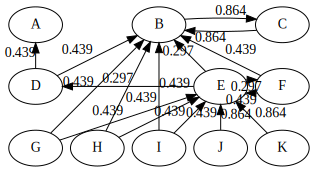

In [23]:
dot = Digraph(engine="neato", comment='PageRank Markov chain')
dot.attr(overlap="false", splines="false", strict="true")

pos = {
    'A': '0,2!',
    'B': '2,2!',
    'C': '4,2!',
    'D': '0,1!',
    'E': '3,1!',
    'F': '4,1!',
    'G': '0,0!',
    'H': '1,0!',
    'I': '2,0!',
    'J': '3,0!',
    'K': '4,0!',
}

for v in outcomePageRank['P_t']:
    dot.node(v, pos=pos[v])

for v in page_graph:
    for w in page_graph[v]:
        if (v,w) in pageRankTransition['table'].keys():
            dot.edge(v, w, str(round(pageRankTransition['table'][(v,w)],3)))

dot

### Running PageRank

  Iter Error
------ --------
     0 0.944608
    10 0.077134
    20 0.015129
    30 0.002978
    40 0.000586
    50 0.000115
    60 0.000023


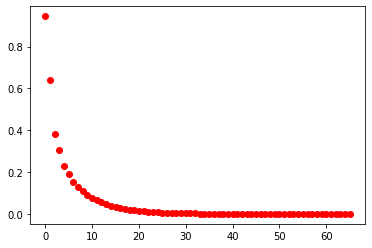

| P   |        Pr |
|-----+-----------|
| A   | 0.0328143 |
| B   | 0.384783  |
| C   | 0.343256  |
| D   | 0.0391262 |
| E   | 0.0809666 |
| F   | 0.0391262 |
| G   | 0.0161856 |
| H   | 0.0161856 |
| I   | 0.0161856 |
| J   | 0.0161856 |
| K   | 0.0161856 |


In [24]:
page_rank = miniforwardConvergence(startPageRank, pageRankTransition, outcomePageRank)
printFactor(page_rank)

We can use ``GraphViz`` to visualise the results of the PageRank algorithm implementation. The next cell tries to mimic the Wikipedia figure.

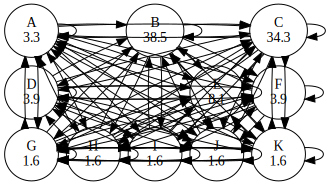

In [25]:
dot = Digraph(engine="neato", comment='PageRank Markov chain')
dot.attr(overlap="false", splines="false", strict="true")

pos = {
    'A': '0,2!',
    'B': '2,2!',
    'C': '4,2!',
    'D': '0,1!',
    'E': '3,1!',
    'F': '4,1!',
    'G': '0,0!',
    'H': '1,0!',
    'I': '2,0!',
    'J': '3,0!',
    'K': '4,0!',
}

for v in outcomePageRank['P_t']:
    dot.node(v, pos=pos[v], label=v+'\n'+str(round(page_rank['table'][(v,)]*100,1)))

for v in outcomePageRank['P_t']:
    for w in outcomePageRank['P_t']:
        if (v,w) in pageRankTransition['table'].keys():
            dot.edge(v, w)

dot

![](./img/page_rank.png)

## Hidden Markov Models (HMMs)

We now turn our attention to HMMs. These are popular dynamic Bayesian Networks. We will implement the forward and Viterbi algorithms and verify how these algorithms provide answers to the questions on the theory part of this tutorial.

We start with the forward algorithm. According to the lecture slides, the forward algorithm for HMMs has the following form:

1. The transition step is similar to Markov chains. In this step, we have a passage of time and the distribution moves towards the stationary distribution.

    $P(x_t|e_{1:t-1}) = \sum_{x_{t-1}}P(x_{t-1}|e_{1:t-1})P(x_t|x_{t-1})$

    where, $P(x_t|e_{1:t-1})$ is the current state before observing the evidence $e_t$. $P(x_{t-1}|e_{1:t-1})$ is the previous state and $P(x_t|x_{t-1})$ is the transition probability.


2. The emission step has the following form:

    $P(x_t|e_{1:t}) \propto P(x_t|e_{1:t-1})P(e_t|x_t)$

    where, $P(x_t|e_{1:t-1})$ is the current state after observing the evidence $e_t$. $P(x_t|e_{1:t-1})$ is the current state before observing de evidence (obtained in the previous step) and $P(e_t|x_t)$ is the emission probability.


The symbol $\propto$ means that the emission step requires a normalization. The normalization is necessary because we are omitting the denominator in the emission update. The denominator is the probability of the evidence, which we frequently do not have readily available. Although we can compute such quantity, the normalization is usually easier to calculate.

### Exercise

Let's implement the forward algorithm for HMMs. From the above equations, we will need to set the evidence and renormalize factors. Therefore, we bring these functions from previous tutorials to the next cell. We recommend you use your functions.

In [28]:
def evidence(var, e, outcomeSpace):
    """
    argument 
    `var`, a valid variable identifier.
    `e`, the observed value for var.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns dictionary with a copy of outcomeSpace with var = e
    """    
    newOutcomeSpace = outcomeSpace.copy()      # Make a copy of outcomeSpace
    newOutcomeSpace[var] = (e,)                # Replace the domain of variable var with a tuple with a single element e. 1 line
    return newOutcomeSpace

def normalize(f):
    """
    argument 
    `f`, factor to be normalized.
    
    Returns a new factor f' as a copy of f with entries that sum up to 1
    """ 
    table = list()
    sum = 0
    for k, p in f['table'].items():
        sum = sum + p
    for k, p in f['table'].items():
        table.append((k, p/sum))
    return {'dom': f['dom'], 'table': odict(table)}

We are in position now to implement the online version of forward algorithm for HMMs. This function will compute just one step of the forward algorithm. Such a step is composed by one time passage plus one observation of evidence.

To make this function more flexible, we will allow the user to pass an empty emission value. This means that no evidence was observed in this step. Also, the renormalization will be optional, so we will keep it commented for now.

Let us code this function. We have created a stub for you.

In [ ]:
def forwardOnline(f, transition, emission, stateVar, emissionVar, emissionEvi, outcomeSpace):
    """
    argument 
    `f`, factor that represents the previous state.
    `transition`, transition probabilities from time t-1 to t.
    `emission`, emission probabilities.
    `stateVar`, state (hidden) variable.
    `emissionVar`, emission variable.
    `emissionEvi`, emission observed evidence. If undef, we do only the time update
    `outcomeSpace`, dictionary with the domain of each variable.
    
    Returns a new factor that represents the current state.
    """

    # Set fCurrent as a copy of f
    fCurrent = f.copy();
    # Set the f_previous domain to be a list with a single variable name appended with '_t-1' to indicate previous time step
    fCurrent['dom'] = (stateVar + '_t-1', )       
    # Make the join operation between fCurrent and the transition probability table
    fCurrent = join(fCurrent, transition, outcomeSpace)
    # Marginalize the randVariable_t-1
    fCurrent = None                                                                          # 1 line
    # If emissionEvi == None, we will assume this time step has no observed evidence
    if emissionEvi != None:                                                         # WARNING! Do not change this line
        # Set evidence in the form emissionVar = emissionEvi
        newOutcomeSpace = None                                                              # 1 line
        # Make the join operation between fCurrent and the emission probability table. Use the newOutcomeSpace
        fCurrent = None                                                                     # 1 line
        # Marginalize emissionVar. Use the newOutcomeSpace
        fCurrent = None                                                                     # 1 line
        # Normalize fCurrent, optional step. Keep the next line commented for now
        # fCurrent = None
    # Set the domain of w to be name of the random variable without time index
    fCurrent['dom'] = (stateVar, )
    return fCurrent

In [34]:
# Answer

def forwardOnline(f, transition, emission, stateVar, emissionVar, emissionEvi, outcomeSpace):
    """
    argument 
    `f`, factor that represents the previous state.
    `transition`, transition probabilities from time t-1 to t.
    `emission`, emission probabilities.
    `stateVar`, state (hidden) variable.
    `emissionVar`, emission variable.
    `emissionEvi`, emission observed evidence. If undef, we do only the time update
    `outcomeSpace`, dictionary with the domain of each variable.
    
    Returns a new factor that represents the current state.
    """

    # Set fCurrent as a copy of f
    fCurrent = f.copy();
    # Set the f_previous domain to be a list with a single variable name appended with '_t-1' to indicate previous time step
    fCurrent['dom'] = (stateVar + '_t-1', )       
    # Make the join operation between fCurrent and the transition probability table
    fCurrent = join(fCurrent, transition, outcomeSpace)
    # Marginalize the randVariable_t-1
    fCurrent = marginalize(fCurrent, fCurrent['dom'][0], outcomeSpace)
    # If emissionEvi == None, we will assume this time step has no observed evidence    
    if emissionEvi != None:
        # Set evidence in the form emissionVar = emissionEvi
        newOutcomeSpace = evidence(emissionVar, emissionEvi, outcomeSpace)
        # Make the join operation between fCurrent and the emission probability table. Use the newOutcomeSpace
        fCurrent = join(fCurrent, emission, newOutcomeSpace)
        # Marginalize emissionVar. Use the newOutcomeSpace
        fCurrent = marginalize(fCurrent, emissionVar, newOutcomeSpace) 
        # Normalize fCurrent, optional step
        #fCurrent = normalize(fCurrent)
    # Set the domain of w to be name of the random variable without time index
    fCurrent['dom'] = (stateVar, )
    return fCurrent

Let's use the weather example from the lecture to test our implementation. In this example, a graduate student tries to figure out the current weather state by observing this advisor carrying an umbrella.

These are the transition and emission probabilities:

In [35]:
##################
# Test code

# possible outcomes, by variable
outcomeSpace = {
    'Weather_t-1':('sun','rain'),
    'Weather_t':('sun','rain'),
    'Umbrella_t': ('umbrella', 'no_umbrella'),
}

# The start state, in this case let's assume we start in a sunny day
weatherStart = {
    'dom': ('Weather',), 
    'table': odict([
        (('sun',), 0.5),
        (('rain',), 0.5),
    ])
}

weatherTransition = {
    'dom': ('Weather_t-1', 'Weather_t'), 
    'table': odict([
        (('sun','sun'), 0.7),
        (('sun','rain'), 0.3),
        (('rain','sun'), 0.3),
        (('rain','rain'), 0.7),
    ])
}

weatherEmission = {
    'dom': ('Weather_t', 'Umbrella_t'), 
    'table': odict([
        (('sun','umbrella'), 0.2),
        (('sun','no_umbrella'), 0.8),
        (('rain','umbrella'), 0.9),
        (('rain','no_umbrella'), 0.1),        
    ])
}

printFactor(forwardOnline(weatherStart, weatherTransition, weatherEmission, 'Weather', 'Umbrella_t', 'umbrella', outcomeSpace))
print()
printFactor(forwardOnline(weatherStart, weatherTransition, weatherEmission, 'Weather', 'Umbrella_t', None, outcomeSpace))

| Weather   |   Pr |
|-----------+------|
| sun       | 0.1  |
| rain      | 0.45 |

| Weather   |   Pr |
|-----------+------|
| sun       |  0.5 |
| rain      |  0.5 |


If you implemented your code correctly, you should see an output like this:

```
| Weather   |   Pr |
|-----------+------|
| sun       | 0.1  |
| rain      | 0.45 |

| Weather   |   Pr |
|-----------+------|
| sun       |  0.5 |
| rain      |  0.5 |
```

### Exercise

Let's now implement the batch version of the forward algorithm. The batch version takes as input a sequence of `n` observations and outputs an array of length `n` with the state distribution at each time step.

We have created a stub for you. You should pass as argument a list of evidence observations. Call the online version of the algorithm as many times as you have items in the emissionEviList.

In [36]:
def forwardBatch(f, transition, emission, stateVar, emissionVar, emissionEviList, outcomeSpace):
    """
    argument 
    `f`, factor that represents the previous state.
    `transition`, transition probabilities from time t-1 to t.
    `emission`, emission probabilities.
    `stateVar`, state (hidden) variable.
    `emissionVar`, emission variable.
    `emissionEviList`, emission observed evidence.
    `outcomeSpace`, dictionary with the domain of each variable.
    
    Returns a vector with all state distributions over time.
    """
    timeLine = []
    # Set fCurrent as a copy of f
    fCurrent = f.copy()
    for emissionEvi in emissionEviList:
        # Call the online version of the forward algorithm to update one time step
        fCurrent = None                                                                    # 1 line
        timeLine.append(fCurrent)
    return timeLine

#################
# Test code
timeLine = forwardBatch(weatherStart, weatherTransition, weatherEmission, 'Weather', 'Umbrella_t', ('umbrella', 'umbrella'), outcomeSpace)
for t in range(len(timeLine)):
    print("Time: ", t)
    printFactor(timeLine[t])
    print()

Time:  0


TypeError: 'NoneType' object is not subscriptable

In [39]:
# Answer

def forwardBatch(f, transition, emission, stateVar, emissionVar, emissionEviList, outcomeSpace):
    """
    argument 
    `f`, factor that represents the previous state.
    `transition`, transition probabilities from time t-1 to t.
    `emission`, emission probabilities.
    `stateVar`, state (hidden) variable.
    `emissionVar`, emission variable.
    `emissionEviList`, emission observed evidence.
    `outcomeSpace`, dictionary with the domain of each variable.
    
    Returns a vector with all state distributions over time.
    """
    timeLine = []
    # Set fCurrent as a copy of f
    fCurrent = f.copy()
    for emissionEvi in emissionEviList:
        # Call the online version of the forward algorithm to update one time step
        fCurrent = forwardOnline(fCurrent, transition, emission, stateVar, emissionVar, emissionEvi, outcomeSpace)
        timeLine.append(fCurrent)
    return timeLine

#################
# Test code
timeLine = forwardBatch(weatherStart, weatherTransition, weatherEmission, 'Weather', 'Umbrella_t', ('umbrella', 'umbrella'), outcomeSpace)
for t in range(len(timeLine)):
    print("Time: ", t)
    printFactor(timeLine[t])
    print()

Time:  0
| Weather   |   Pr |
|-----------+------|
| sun       | 0.1  |
| rain      | 0.45 |

Time:  1
| Weather   |     Pr |
|-----------+--------|
| sun       | 0.041  |
| rain      | 0.3105 |



Now, let's implement the Viterbi algorithm. The Viterbi algorithm provides answers to queries in the form of the most likely explanation (MLE). In other words, the output will be the most likely instantiation for each of the hidden states.

According to the course slides, the Viterbi algorithm has the following equations:

$m_t[x_t] = P(e_t|x_t) max_{x_{t-1}}P(x_t|x_{t-1})m_{t-1}[x_{t-1}]$

where, 

- $m_t[x_t]$ is the MLE for time $t$.
- $P(e_t|x_t)$ is the emission probability.
- $P(x_t|x_{t-1})$ is the transition probability.
- $m_{t-1}[x_{t-1}]$ is the MLE for time $t-1$.

### Exercise

To implement the Viterbi algorithm, we will need an intermediate operation `maximize`. Such an operation is similar to `marginalize` in the sense that it will eliminate one variable of a factor. However, instead of summing out this variable, we will compute the maximum among the entries.

We have created a stub for you. You will need to complete a few gaps.

In [40]:
def maximize(f, var, outcomeSpace):
    """
    argument 
    `f`, factor to be marginalized.
    `var`, variable to be maximized out.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns a new factor f' with dom(f') = dom(f) - {var}
    """    
    
    # Let's make a copy of f domain and convert it to a list. We need a list to be able to modify its elements
    new_dom = list(f['dom'])
    new_dom.remove(var)            # Remove var from the list new_dom by calling the method remove(). 1 line
    table = list()                 # Create an empty list for table. We will fill in table from scratch. 1 line
    for entries in product(*[outcomeSpace[node] for node in new_dom]):
        #########################
        # Insert your code here #
        #########################        
        m = -1;                    # Initialize the maximization variable m. 1 line

        # We need to iterate over all possible outcomes of the variable var
        for val in outcomeSpace[var]:
            # To modify the tuple entries, we will need to convert it to a list
            entriesList = list(entries)
            # We need to insert the value of var in the right position in entriesList
            entriesList.insert(f['dom'].index(var), val)
            
            #########################
            # Insert your code here #
            #########################
            p = prob(f, *tuple(entriesList))                        # Calculate the probability of factor f for entriesList. 1 line
            m = max(m, p)                       # Maximize over all values of var by storing the max value in m. 1 line
            
        # Create a new table entry with the multiplication of p1 and p2
        table.append((entries, m))
    return {'dom': tuple(new_dom), 'table': odict(table)}

################
# Test code

printFactor(maximize(weatherEmission, 'Umbrella_t', outcomeSpace))

| Weather_t   |   Pr |
|-------------+------|
| sun         |  0.8 |
| rain        |  0.9 |


In [41]:
# Answer

def maximize(f, var, outcomeSpace):
    """
    argument 
    `f`, factor to be marginalized.
    `var`, variable to be maximized out.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns a new factor f' with dom(f') = dom(f) - {var}
    """    
    
    # Let's make a copy of f domain and convert it to a list. We need a list to be able to modify its elements
    new_dom = list(f['dom'])
    
    new_dom.remove(var)            # Remove var from the list new_dom by calling the method remove(). 1 line
    table = list()                 # Create an empty list for table. We will fill in table from scratch. 1 line
    for entries in product(*[outcomeSpace[node] for node in new_dom]):
        m = -1;                    # Initialize the maximization variable m. 1 line

        # We need to iterate over all possible outcomes of the variable var
        for val in outcomeSpace[var]:
            # To modify the tuple entries, we will need to convert it to a list
            entriesList = list(entries)
            # We need to insert the value of var in the right position in entriesList
            entriesList.insert(f['dom'].index(var), val)

            p = prob(f, *tuple(entriesList))     # Calculate the probability of factor f for entriesList. 1 line
            m = max(m, p)                        # Maximize over all values of var by storing the max value in m. 1 line
            
        # Create a new table entry with the multiplication of p1 and p2
        table.append((entries, m))
    return {'dom': tuple(new_dom), 'table': odict(table)}

################
# Test code

printFactor(maximize(weatherEmission, 'Umbrella_t', outcomeSpace))

| Weather_t   |   Pr |
|-------------+------|
| sun         |  0.8 |
| rain        |  0.9 |


If your implementation is correct, you should see the following output:

```
| Weather_t   |   Pr |
|-------------+------|
| sun         |  0.8 |
| rain        |  0.9 |
```

### Exercise

Now we are in the position to implement the Viterbi algorithm. We have started the implementation and left a few details for you to fill in. As before, we will code the online version first. The online version provides the output for a single time and evidence observation increment. The batch version is a simple extension of the online algorithm.

In [ ]:
def viterbiOnline(f, transition, emission, stateVar, emissionVar, emissionEvi, outcomeSpace):
    """
    argument 
    `f`, factor that represents the previous state.
    `transition`, transition probabilities from time t-1 to t.
    `emission`, emission probabilities.
    `stateVar`, state (hidden) variable.
    `emissionVar`, emission variable.
    `emissionEvi`, emission observed evidence. If undef, we do only the time update
    `outcomeSpace`, dictionary with the domain of each variable.
    
    Returns a new factor that represents the current state.
    """ 

    # Set fCurrent as a copy of f
    fCurrent = f.copy();
    # Set the f_previous domain to be a list with a single variable name appended with '_t-1' to indicate previous time step
    fCurrent['dom'] = (stateVar + '_t-1', )       
    # Make the join operation between fCurrent and the transition probability table    
    fCurrent = None                                                                    # 1 line
    # Eliminate the randVariable_t-1 with the maximization operation
    fCurrent = None                                                                    # 1 line
    # If emissionEvi == None, we will assume this time step has no observed evidence    
    if emissionEvi != None:                                                            # WARNING: do not change this line
        # Set evidence in the form emissionVar = emissionEvi    
        newOutcomeSpace = None                                                         # 1 line
        # Make the join operation between fCurrent and the emission probability table. Use the newOutcomeSpace    
        fCurrent = None                                                                # 1 line
        # Marginalize emissionVar. Use the newOutcomeSpace    
        fCurrent = None                                                                # 1 line       
        # Normalize fcurrent. Keep the next line commented for now
        # fCurrent = None                                                              # 1 line
    # Set the domain of w to be name of the random variable without time index
    fCurrent['dom'] = (stateVar, )
    return fCurrent

##################
# Test code

printFactor(viterbiOnline(weatherStart, weatherTransition, weatherEmission, 'Weather', 'Umbrella_t', 'umbrella', outcomeSpace))

In [48]:
# Answer

def viterbiOnline(f, transition, emission, stateVar, emissionVar, emissionEvi, outcomeSpace):
    """
    argument 
    `f`, factor that represents the previous state.
    `transition`, transition probabilities from time t-1 to t.
    `emission`, emission probabilities.
    `stateVar`, state (hidden) variable.
    `emissionVar`, emission variable.
    `emissionEvi`, emission observed evidence. If undef, we do only the time update
    `outcomeSpace`, dictionary with the domain of each variable.
    
    Returns a new factor that represents the current state.
    """ 

    # Set fCurrent as a copy of f
    fCurrent = f.copy();
    # Set the f_previous domain to be a list with a single variable name appended with '_t-1' to indicate previous time step
    fCurrent['dom'] = (stateVar + '_t-1', )       
    # Make the join operation between fCurrent and the transition probability table    
    fCurrent = join(fCurrent, transition, outcomeSpace)
    # Eliminate the randVariable_t-1 with the maximization operation
    fCurrent = maximize(fCurrent, fCurrent['dom'][0], outcomeSpace)
    #print(fCurrent)
    # If emissionEvi == None, we will assume this time step has no observed evidence    
    if emissionEvi != None:
        # Set evidence in the form emissionVar = emissionEvi    
        newOutcomeSpace = evidence(emissionVar, emissionEvi, outcomeSpace)
        # Make the join operation between fCurrent and the emission probability table. Use the newOutcomeSpace    
        fCurrent = join(fCurrent, emission, newOutcomeSpace)
        # Marginalize emissionVar. Use the newOutcomeSpace    
        fCurrent = marginalize(fCurrent, emissionVar, newOutcomeSpace)        
        # Normalize fcurrent. Keep the next line commented for now
        # fCurrent = normalize(fCurrent)
    # Set the domain of w to be name of the random variable without time index
    fCurrent['dom'] = (stateVar, )
    return fCurrent

##################
# Test code

printFactor(viterbiOnline(weatherStart, weatherTransition, weatherEmission, 'Weather', 'Umbrella_t', 'umbrella', outcomeSpace))

| Weather   |    Pr |
|-----------+-------|
| sun       | 0.07  |
| rain      | 0.315 |


If your implementation is correct, you should see the following output:

```
| Weather   |    Pr |
|-----------+-------|
| sun       | 0.07  |
| rain      | 0.315 |
```

### Exercise

Now, implement the batch version of the Viterbi algorithm by calling the online function multiple times. Call the online version once for each observation in `emissionEviList`.

In [ ]:
def viterbiBatch(f, transition, emission, stateVar, emissionVar, emissionEviList, outcomeSpace):
    """
    argument 
    `f`, factor that represents the previous state.
    `transition`, transition probabilities from time t-1 to t.
    `emission`, emission probabilities.
    `stateVar`, state (hidden) variable.
    `emissionVar`, emission variable.
    `emissionEviList`, emission observed evidence.
    `outcomeSpace`, dictionary with the domain of each variable.
    
    Returns a new factor that represents the current state.
    """      
    timeLine = []
    # Set fCurrent as a copy of f
    fCurrent = f.copy()
    for emissionEvi in emissionEviList:
        # Call the online version of the Viterbi algorithm to update one time step
        fCurrent = None                                                                    # 1 line
        # Print the current factor for debugging
        timeLine.append(fCurrent)
    return timeLine

#################
# Test code
timeLine = viterbiBatch(weatherStart, weatherTransition, weatherEmission, 'Weather', 'Umbrella_t', ('umbrella', 'umbrella'), outcomeSpace)
for t in range(len(timeLine)):
    print("Time: ", t)
    printFactor(timeLine[t])
    print()

In [49]:
# Answer

def viterbiBatch(f, transition, emission, stateVar, emissionVar, emissionEviList, outcomeSpace):
    """
    argument 
    `f`, factor that represents the previous state.
    `transition`, transition probabilities from time t-1 to t.
    `emission`, emission probabilities.
    `stateVar`, state (hidden) variable.
    `emissionVar`, emission variable.
    `emissionEviList`, emission observed evidence.
    `outcomeSpace`, dictionary with the domain of each variable.
    
    Returns a new factor that represents the current state.
    """      
    timeLine = []
    # Set fCurrent as a copy of f
    fCurrent = f.copy()
    for emissionEvi in emissionEviList:
        # Call the online version of the Viterbi algorithm to update one time step
        fCurrent = viterbiOnline(fCurrent, transition, emission, stateVar, emissionVar, emissionEvi, outcomeSpace)
        # Print the current factor for debugging
        timeLine.append(fCurrent)
    return timeLine

#################
# Test code
timeLine = viterbiBatch(weatherStart, weatherTransition, weatherEmission, 'Weather', 'Umbrella_t', ('umbrella', 'umbrella'), outcomeSpace)
for t in range(len(timeLine)):
    print("Time: ", t)
    printFactor(timeLine[t])
    print()

Time:  0
| Weather   |    Pr |
|-----------+-------|
| sun       | 0.07  |
| rain      | 0.315 |

Time:  1
| Weather   |      Pr |
|-----------+---------|
| sun       | 0.0189  |
| rain      | 0.19845 |



If your implementation is correct, you should see the following output:

```
Time:  0
| Weather   |    Pr |
|-----------+-------|
| sun       | 0.07  |
| rain      | 0.315 |

Time:  1
| Weather   |      Pr |
|-----------+---------|
| sun       | 0.0189  |
| rain      | 0.19845 |
```

Before we conclude with an exercise, here are some suggestions of ways to improve the source code of this tutorial:

1. The forward algorithm typically does not normalize the intermediate results. You can make this step optional with a flag. This change can also be done to the Viterbi algorithm.

2. If you do not normalize, the probabilities will assume small values due to the sequence of multiplications. In this case, operating with log-probabilities will decrease the chance of having underflows.

3. For simplicity, we are assuming the update steps are composed by a transition followed by emission. But it is not always the case. It would be better if these steps can be inverted or, even better, implemented independently.

## Finding the MPE Assignment

As we discussed in the lecture, we can find the MPE assigment from the output computed by the Viterbi algorithm. Remember, that the correct assignment is obtained when we trace back the computations, starting with the last state and move towards the first state. There are two main approaches for finding the MPE assignment:

1. Use an additional data structure to store pointers indicating the path of the highest probability.

2. Use the output of the Viterbi algorithm and trace back the computations.

In the next cell, we provide a function to find the MPE assignment given the output of the ``viterbi`` function. The ``traceback`` function has some technical difficulties due to the need to deal with zero probabilities (which could cause a division by zero in the trace back procedure) and comparison of float numbers.

In [50]:
def traceBack(timeLine, start, transition, emission, stateVar, emissionVar, emissionEviList, outcomeSpace):
    """
    argument 
    `f`, factor that represents the previous state.
    `transition`, transition probabilities from time t-1 to t.
    `emission`, emission probabilities.
    `stateVar`, state (hidden) variable.
    `emissionVar`, emission variable.
    `emissionEviList`, emission observed evidence.
    `outcomeSpace`, dictionary with the domain of each variable.
    
    Returns an array with the MLE assignment.
    """ 

    t = len(timeLine) - 1
    mleList = [outcomeSpace[stateVar][0]] * (t+1)
    mleList[t] = max(timeLine[t]['table'], key=timeLine[t]['table'].get)[0]
    p = prob(timeLine[t], mleList[t])
    for t in range(t,0,-1):
        p_e = prob(emission, mleList[t], emissionEviList[t])
        for state in outcomeSpace[stateVar]:
            p_t = prob(transition, state, mleList[t])
            if p_t != 0 and p_e!=0:
                if abs(prob(timeLine[t-1], state) - p/p_e/p_t) < 0.00000001:
                    mleList[t-1] = state
                    p = prob(timeLine[t-1], state)
    p_e = prob(emission, mleList[0], emissionEviList[0])
    for state in outcomeSpace[stateVar]:
        p_t = prob(transition, state, mleList[0])
        if p_t != 0 and p_e != 0:       
            if abs(prob(start, state) - p/p_e/p_t) < 0.00000001:
                mleList[0] = state
                p = prob(timeLine[0], state)
    return mleList

####################
## Test code

mpe = traceBack(timeLine, weatherStart, weatherTransition, weatherEmission, 'Weather_t', 'Umbrella_t', ('umbrella', 'umbrella'), outcomeSpace)
print(mpe)

['rain', 'rain']


### Exercise

You can use the implemented code to find the numerical answers to the questions of the theory part of this tutorial.

### Question 1

Lisa is given a fair coin $C_1$ and asked to flip it eight times in a row. Lisa also has a biased coin $C_2$ with probability 0.8 of landing heads. All we know is that Lisa flipped the fair coin initially but we believe that she intends to switch to the biased coin and that she tends to be 10% successful in performing the switch. Suppose that we observe the outcome of the eight coin flips and want to find out whether Lisa managed to perform a coin switch and when. What is the solution to this problem assuming that the flips came out as follows:

    a. tails, tails, tails, heads, heads, heads, heads, heads
    b. tails, tails, heads, heads, heads, heads, heads, heads

In [51]:

outcomeSpaceLisa = {
    "C_t":('fair','biased'),
    "C_t-1":('fair','biased'),
}

transitionLisa = {
    'dom':('C_t-1','C_t'),
    'table':odict([
        (('fair','fair'),0.9),
        (('fair','biased'),0.1),
        (('biased','fair'),0.0),
        (('biased','biased'),1.0),
    ])
}

startLisa = {
    'dom':('C',),
    'table':odict([
        (('fair',),1.0),
        (('biased',),0.0),
    ])
}

evidenceLisa = {
    'dom':('C_t','U_t'),
    'table':odict([
        (('fair','heads'),0.5),
        (('fair','tails'),0.5),
        (('biased','heads'),0.8),
        (('biased','tails'),0.2),
    ])
}


In [52]:
# Answer

outcomeSpaceLisa = {
    "C_t":('fair','biased'),
    "C_t-1":('fair','biased'),
}

transitionLisa = {
    'dom': ('C_t-1', 'C_t'), 
    'table': odict([
        (('fair','fair'), 0.9),
        (('fair','biased'), 0.1),
        (('biased','fair'), 0.0),
        (('biased','biased'), 1.0),        
    ])
}

startLisa = {
    'dom': ('C',), 
    'table': odict([
        (('fair',), 1.0),
        (('biased',), 0.0),
    ])
}

evidenceLisa = {
    'dom': ('C_t', 'U_t'), 
    'table': odict([
        (('fair','heads'), 0.5),
        (('fair','tails'), 0.5),
        (('biased','heads'), 0.8),
        (('biased','tails'), 0.2),
    ])
}
    
timeLine = viterbiBatch(startLisa, transitionLisa, evidenceLisa, 'C', 'U_t', ('tails', 'tails', 'tails', 'heads', 'heads', 'heads', 'heads', 'heads'), outcomeSpaceLisa)
for t in range(len(timeLine)):
    print("Time: ", t)
    printFactor(timeLine[t])
    print()

mleList = traceBack(timeLine, startLisa, transitionLisa, evidenceLisa, 'C_t', 'U_t', ('tails', 'tails', 'tails', 'heads', 'heads', 'heads', 'heads', 'heads'), outcomeSpaceLisa)
for t in range(len(mleList)):
    print("Time: ", t)
    print(mleList[t])
    print()
    
timeLine = viterbiBatch(startLisa, transitionLisa, evidenceLisa, 'C', 'U_t', ('tails', 'tails', 'heads', 'heads', 'heads', 'heads', 'heads', 'heads'), outcomeSpaceLisa)
for t in range(len(timeLine)):
    print("Time: ", t)
    printFactor(timeLine[t])
    print()

mleList = traceBack(timeLine, startLisa, transitionLisa, evidenceLisa, 'C_t', 'U_t', ('tails', 'tails', 'heads', 'heads', 'heads', 'heads', 'heads', 'heads'), outcomeSpaceLisa)
for t in range(len(mleList)):
    print("Time: ", t)
    print(mleList[t])
    print()    

Time:  0
| C      |   Pr |
|--------+------|
| fair   | 0.45 |
| biased | 0.02 |

Time:  1
| C      |     Pr |
|--------+--------|
| fair   | 0.2025 |
| biased | 0.009  |

Time:  2
| C      |       Pr |
|--------+----------|
| fair   | 0.091125 |
| biased | 0.00405  |

Time:  3
| C      |        Pr |
|--------+-----------|
| fair   | 0.0410063 |
| biased | 0.00729   |

Time:  4
| C      |        Pr |
|--------+-----------|
| fair   | 0.0184528 |
| biased | 0.005832  |

Time:  5
| C      |         Pr |
|--------+------------|
| fair   | 0.00830377 |
| biased | 0.0046656  |

Time:  6
| C      |         Pr |
|--------+------------|
| fair   | 0.00373669 |
| biased | 0.00373248 |

Time:  7
| C      |         Pr |
|--------+------------|
| fair   | 0.00168151 |
| biased | 0.00298598 |

Time:  0
fair

Time:  1
fair

Time:  2
fair

Time:  3
biased

Time:  4
biased

Time:  5
biased

Time:  6
biased

Time:  7
biased

Time:  0
| C      |   Pr |
|--------+------|
| fair   | 0.45 |
| biased | 0.02

### Question 2

Consider a cow that may be infected with a disease that can possibly be detected by performing a milk test. The test is performed on five consecutive days, leading to five outcomes. We want to determine the state of the cow's infection over these days given the test outcomes. The prior probability of an infection on day one is 1/10,000; the test false positive rate is 5/1,000; and its false negative rate is 1/1,000. Moreover, the state of infection at a given day depends only on its state at the previous day. In particular, the probability of a new infection on a given day is 2/10,000, while the probability that an infection would persist to the next day os 7/10.

What is the most likely state of the cow's infection over the five days given the following test outcomes:

    a. positive, positive, negative, positive, positive
    b. positive, negative, negative, positive, positive
    c. positive, nagetive, negative, negative, positive

In [53]:
# Answer

outcomeSpaceCow = {
    "Cow_t":('healthy','infected'),
    "Cow_t-1":('healthy','infected'),
}

transitionCow = {
    'dom': ('Cow_t-1', 'Cow_t'), 
    'table': odict([
        (('healthy','healthy'), 9998/10000),
        (('healthy','infected'), 2/10000),
        (('infected','healthy'), 3/10),
        (('infected','infected'), 7/10),        
    ])
}

startCow = {
    'dom': ('Cow',), 
    'table': odict([
        (('healthy',), 9999/10000),
        (('infected',), 1/10000),
    ])
}

evidenceCow = {
    'dom': ('Cow_t', 'Test_t'), 
    'table': odict([
        (('healthy','positive'), 5/1000),
        (('healthy','negative'), 995/1000),
        (('infected','positive'), 999/1000),
        (('infected','negative'), 1/1000),
    ])
}

timeLine = viterbiBatch(startCow, transitionCow, evidenceCow, 'Cow', 'Test_t', ('positive', 'positive', 'negative', 'positive', 'positive'), outcomeSpaceCow)
for t in range(len(timeLine)):
    print("Time: ", t)
    printFactor(timeLine[t])
    print()

mleList = traceBack(timeLine, startCow, transitionCow, evidenceCow, 'Cow_t', 'Test_t', ('positive', 'positive', 'negative', 'positive', 'positive'), outcomeSpaceCow)
for t in range(len(mleList)):
    print("Time: ", t)
    print(mleList[t])
    print()

timeLine = viterbiBatch(startCow, transitionCow, evidenceCow, 'Cow', 'Test_t', ('positive', 'negative', 'negative', 'positive', 'positive'), outcomeSpaceCow)
for t in range(len(timeLine)):
    print("Time: ", t)
    printFactor(timeLine[t])
    print()

mleList = traceBack(timeLine, startCow, transitionCow, evidenceCow, 'Cow_t', 'Test_t', ('positive', 'negative', 'negative', 'negative', 'positive'), outcomeSpaceCow)
for t in range(len(mleList)):
    print("Time: ", t)
    print(mleList[t])
    print()
    
timeLine = viterbiBatch(startCow, transitionCow, evidenceCow, 'Cow', 'Test_t', ('positive', 'positive', 'negative', 'positive', 'positive'), outcomeSpaceCow)
for t in range(len(timeLine)):
    print("Time: ", t)
    printFactor(timeLine[t])
    print()

mleList = traceBack(timeLine, startCow, transitionCow, evidenceCow, 'Cow_t', 'Test_t', ('positive', 'positive', 'negative', 'positive', 'positive'), outcomeSpaceCow)
for t in range(len(mleList)):
    print("Time: ", t)
    print(mleList[t])
    print()

Time:  0
| Cow      |         Pr |
|----------+------------|
| healthy  | 0.0049985  |
| infected | 0.00019978 |

Time:  1
| Cow      |          Pr |
|----------+-------------|
| healthy  | 2.49875e-05 |
| infected | 0.000139706 |

Time:  2
| Cow      |          Pr |
|----------+-------------|
| healthy  | 4.17023e-05 |
| infected | 9.77943e-08 |

Time:  3
| Cow      |          Pr |
|----------+-------------|
| healthy  | 2.0847e-07  |
| infected | 6.83876e-08 |

Time:  4
| Cow      |          Pr |
|----------+-------------|
| healthy  | 1.04214e-09 |
| infected | 4.78234e-08 |

Time:  0
healthy

Time:  1
infected

Time:  2
infected

Time:  3
infected

Time:  4
infected

Time:  0
| Cow      |         Pr |
|----------+------------|
| healthy  | 0.0049985  |
| infected | 0.00019978 |

Time:  1
| Cow      |          Pr |
|----------+-------------|
| healthy  | 0.00497251  |
| infected | 1.39846e-07 |

Time:  2
| Cow      |          Pr |
|----------+-------------|
| healthy  | 0.00494666  